# Visualization of Scaling Experiments


# Aggregate and Compare Results


In [ ]:
import pandas as pd
import glob
import os

def aggregate_results(results_dir='.', output_filename='summary_results.csv'):
    """
    Aggregates individual result CSV files into a single summary CSV.

    Parameters:
    - results_dir (str): Directory where individual result CSV files are stored.
    - output_filename (str): Name of the aggregated summary CSV file.
    """
    summary_data = []

    # Pattern for advanced models with hidden_dim
    advanced_pattern = os.path.join(results_dir, '*_hidden_results.csv')
    advanced_files = glob.glob(advanced_pattern)

    for file_path in advanced_files:
        base_name = os.path.basename(file_path)
        # Expected format: {dataset_name}_{model_name}_{num_layers}_layers_{hidden_dim}_hidden_results.csv
        parts = base_name.split('_')

        if len(parts) < 6:
            print(f"Filename {base_name} does not match the expected format.")
            continue

        dataset_name = parts[0]
        model_name = parts[1]

        try:
            num_layers = int(parts[2])
            hidden_dim = int(parts[4])
        except ValueError:
            print(f"Cannot parse num_layers or hidden_dim in filename {base_name}.")
            continue

        df = pd.read_csv(file_path)

        if 'val_acc' not in df.columns or 'test_acc' not in df.columns:
            print(f"File {base_name} is missing 'val_acc' or 'test_acc' columns.")
            continue

        best_val_acc = df['val_acc'].max()
        best_epoch = df['val_acc'].idxmax()
        best_test_acc = df.loc[best_epoch, 'test_acc']

        # Approximate total_time if available
        total_time = df['total_time'].iloc[0] if 'total_time' in df.columns else None

        # Assuming num_params is not present; set to None or compute if possible
        num_params = None

        summary_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Layers': num_layers,
            'Hidden_Dim': hidden_dim,
            'num_params': num_params,
            'Best Val Acc': best_val_acc,
            'Best Test Acc': best_test_acc,
            'Total Time (s)': total_time
        })

    # If you have standard result files without hidden_dim, handle them here
    # Example pattern: {dataset_name}_results.csv
    standard_pattern = os.path.join(results_dir, '*_results.csv')
    standard_files = glob.glob(standard_pattern)

    for file_path in standard_files:
        base_name = os.path.basename(file_path)
        # Expected format: {dataset_name}_results.csv
        parts = base_name.split('_')

        if len(parts) != 2:
            print(f"Filename {base_name} does not match the expected standard format.")
            continue

        dataset_name = parts[0]
        model_name = 'GCN'       # Assuming standard results are for GCN with default params
        num_layers = 2           # Default number of layers for GCN
        hidden_dim = 16          # Default hidden dimension for GCN

        df = pd.read_csv(file_path)

        if 'val_acc' not in df.columns or 'test_acc' not in df.columns:
            print(f"File {base_name} is missing 'val_acc' or 'test_acc' columns.")
            continue

        best_val_acc = df['val_acc'].max()
        best_epoch = df['val_acc'].idxmax()
        best_test_acc = df.loc[best_epoch, 'test_acc']

        # Approximate total_time if available
        total_time = df['total_time'].iloc[0] if 'total_time' in df.columns else None

        # Assuming num_params is not present; set to None or compute if possible
        num_params = None

        summary_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Layers': num_layers,
            'Hidden_Dim': hidden_dim,
            'num_params': num_params,
            'Best Val Acc': best_val_acc,
            'Best Test Acc': best_test_acc,
            'Total Time (s)': total_time
        })

    if not summary_data:
        print("No valid result files found.")
        return

    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(by=['Dataset', 'Model', 'Layers'])
    output_path = os.path.join(results_dir, output_filename)
    summary_df.to_csv(output_path, index=False)
    print(f"Aggregated summary results saved to {output_path}")
    print(summary_df)

aggregate_results(results_dir='.', output_filename='summary_results.csv')



Filename PubMed_DeeperGCN_8_layers_24_hidden_results.csv does not match the expected standard format.
Filename Cora_DeeperGCN_16_layers_40_hidden_results.csv does not match the expected standard format.
Filename PubMed_GCN_4_layers_48_hidden_results.csv does not match the expected standard format.
Filename Squirrel_GraphTransformer_8_layers_64_hidden_results.csv does not match the expected standard format.
Filename Chameleon_GCN_16_layers_56_hidden_results.csv does not match the expected standard format.
Filename CiteSeer_GraphTransformer_8_layers_24_hidden_results.csv does not match the expected standard format.
Filename CiteSeer_GCN_16_layers_64_hidden_results.csv does not match the expected standard format.
Filename PubMed_DeeperGCN_16_layers_56_hidden_results.csv does not match the expected standard format.
Filename Chameleon_DeeperGCN_2_layers_16_hidden_results.csv does not match the expected standard format.
Filename PubMed_DeeperGCN_4_layers_24_hidden_results.csv does not match 

In [ ]:
import pandas as pd
import glob
import os
import re

def aggregate_results(results_dir='.', output_filename='summary_results.csv'):
    """
    Aggregates individual result CSV files into a single summary CSV, retaining only the best test accuracy
    for each combination of Dataset, Model, and Number of Layers.

    Parameters:
    - results_dir (str): Directory where individual result CSV files are stored.
    - output_filename (str): Name of the aggregated summary CSV file.
    """
    summary_data = []

    # Define regex patterns for different filename structures
    # Pattern for advanced models with hidden_dim: {dataset}_{model}_{layers}_layers_{hidden_dim}_hidden_results.csv
    pattern_advanced = re.compile(r'^(?P<dataset>\w+)_(?P<model>\w+)_(?P<layers>\d+)_layers_(?P<hidden_dim>\d+)_hidden_results\.csv$')

    # Pattern for advanced models without hidden_dim: {dataset}_{model}_{layers}_layers_results.csv
    pattern_advanced_no_hidden = re.compile(r'^(?P<dataset>\w+)_(?P<model>\w+)_(?P<layers>\d+)_layers_results\.csv$')

    # Pattern for standard models: {dataset}_results.csv
    pattern_standard = re.compile(r'^(?P<dataset>\w+)_results\.csv$')

    # Process all CSV files in the results directory
    csv_files = glob.glob(os.path.join(results_dir, '*.csv'))

    for file_path in csv_files:
        base_name = os.path.basename(file_path)

        match_advanced = pattern_advanced.match(base_name)
        match_advanced_no_hidden = pattern_advanced_no_hidden.match(base_name)
        match_standard = pattern_standard.match(base_name)

        if match_advanced:
            dataset_name = match_advanced.group('dataset')
            model_name = match_advanced.group('model')
            num_layers = int(match_advanced.group('layers'))
            hidden_dim = int(match_advanced.group('hidden_dim'))
        elif match_advanced_no_hidden:
            dataset_name = match_advanced_no_hidden.group('dataset')
            model_name = match_advanced_no_hidden.group('model')
            num_layers = int(match_advanced_no_hidden.group('layers'))
            hidden_dim = None  # Hidden dimension not provided
        elif match_standard:
            dataset_name = match_standard.group('dataset')
            model_name = 'GCN'       # Assuming standard results are for GCN with default parameters
            num_layers = 2           # Default number of layers for GCN
            hidden_dim = 16          # Default hidden dimension for GCN
        else:
            print(f"Filename '{base_name}' does not match any expected patterns. Skipping.")
            continue

        # Read the CSV file
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading '{base_name}': {e}. Skipping.")
            continue

        # Check for required columns
        required_columns = {'val_acc', 'test_acc'}
        if not required_columns.issubset(df.columns):
            print(f"File '{base_name}' is missing one or more required columns: {required_columns}. Skipping.")
            continue

        # Extract best validation accuracy and corresponding test accuracy
        best_val_acc = df['val_acc'].max()
        best_epoch = df['val_acc'].idxmax()
        best_test_acc = df.loc[best_epoch, 'test_acc']

        # Extract total_time if available
        total_time = df['total_time'].iloc[0] if 'total_time' in df.columns else None

        # Extract num_params if available
        num_params = df['num_params'].iloc[0] if 'num_params' in df.columns else None

        # Append the extracted data to summary
        summary_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Layers': num_layers,
            'Hidden_Dim': hidden_dim,
            'num_params': num_params,
            'Best Val Acc': best_val_acc,
            'Best Test Acc': best_test_acc,
            'Total Time (s)': total_time
        })

    if not summary_data:
        print("No valid result files found to aggregate.")
        return

    # Create DataFrame from summary data
    summary_df = pd.DataFrame(summary_data)

    # Sort the DataFrame for better readability
    summary_df = summary_df.sort_values(by=['Dataset', 'Model', 'Layers'])

    # Group by Dataset, Model, Layers and keep the row with the highest 'Best Test Acc'
    summary_df = summary_df.sort_values('Best Test Acc', ascending=False).drop_duplicates(subset=['Dataset', 'Model', 'Layers'])

    # Save the aggregated summary to CSV
    output_path = os.path.join(results_dir, output_filename)
    summary_df.to_csv(output_path, index=False)
    print(f"Aggregated summary results saved to '{output_path}'.")
    print(summary_df)

aggregate_results(results_dir='.', output_filename='summary_results.csv')



Filename 'all_datasets_summary.csv' does not match any expected patterns. Skipping.
Filename 'advanced_models_summary.csv' does not match any expected patterns. Skipping.
Aggregated summary results saved to './summary_results.csv'.
       Dataset             Model  Layers  Hidden_Dim num_params  Best Val Acc  \
544      Texas  GraphTransformer       2          16       None      0.779661   
441       Cora               GCN       4          48       None      0.812000   
267       Cora               GCN       2          48       None      0.792000   
311     PubMed               GCN       2          40       None      0.794000   
302       Cora         DeeperGCN       2          64       None      0.758000   
..         ...               ...     ...         ...        ...           ...   
288   Squirrel               GCN      16          56       None      0.284856   
203  Chameleon               GCN      16          40       None      0.293553   
292   Squirrel               GCN       

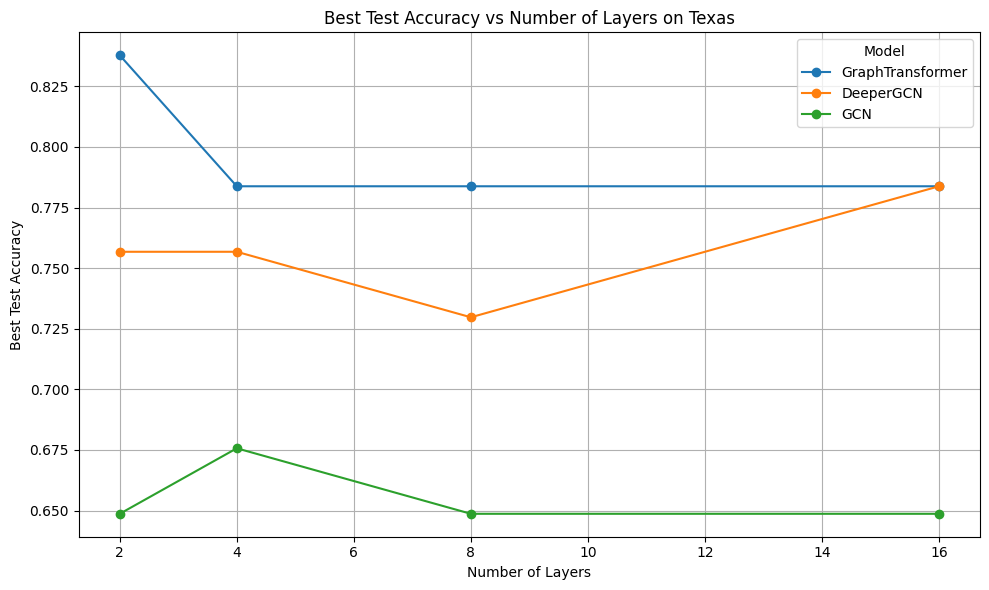

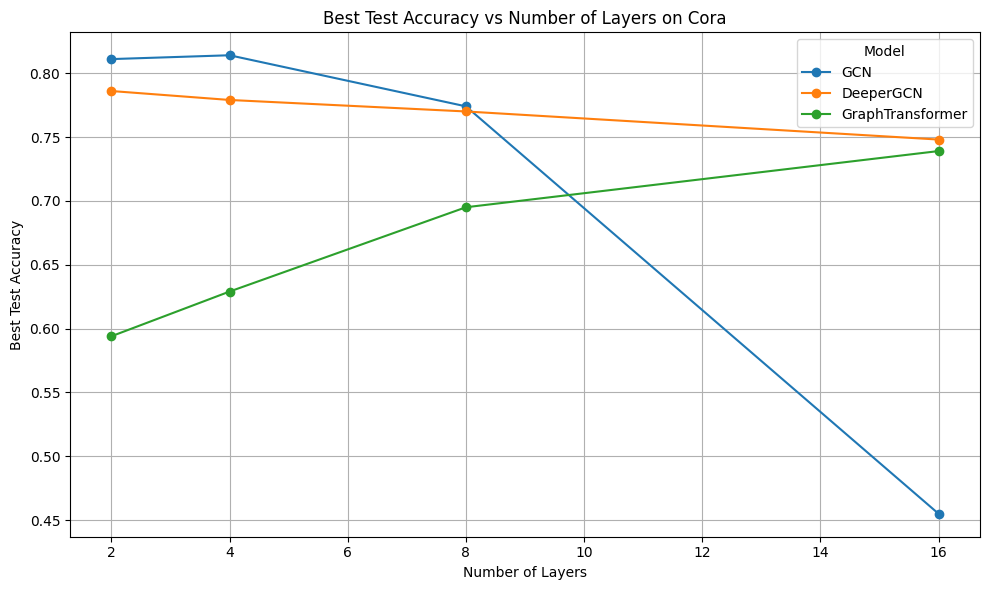

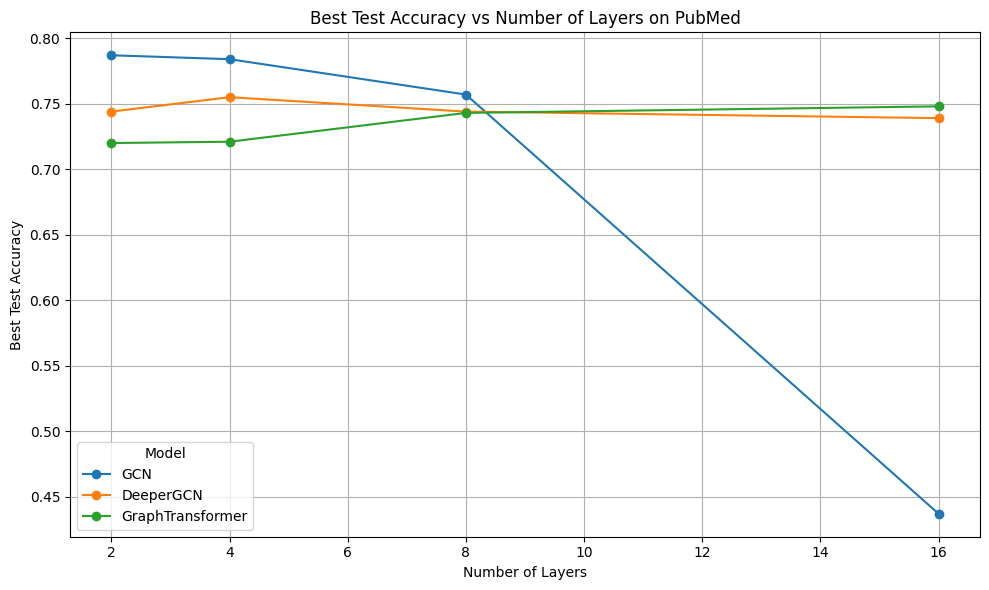

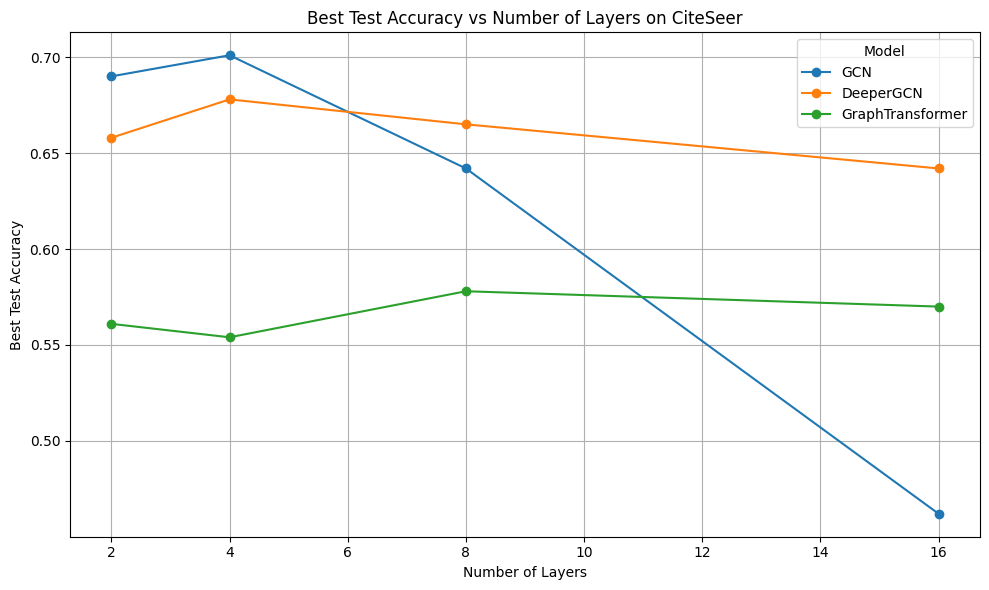

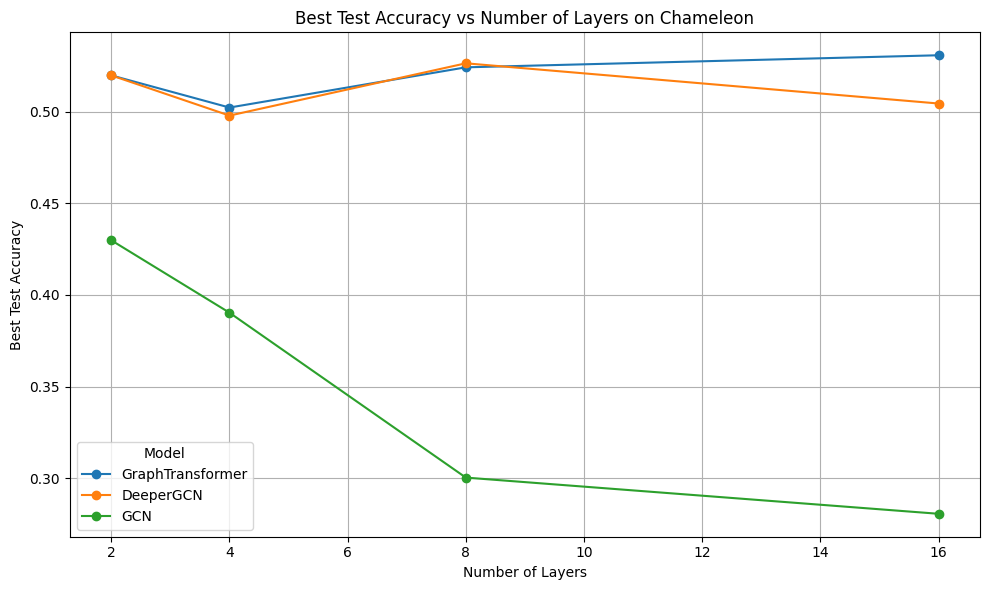

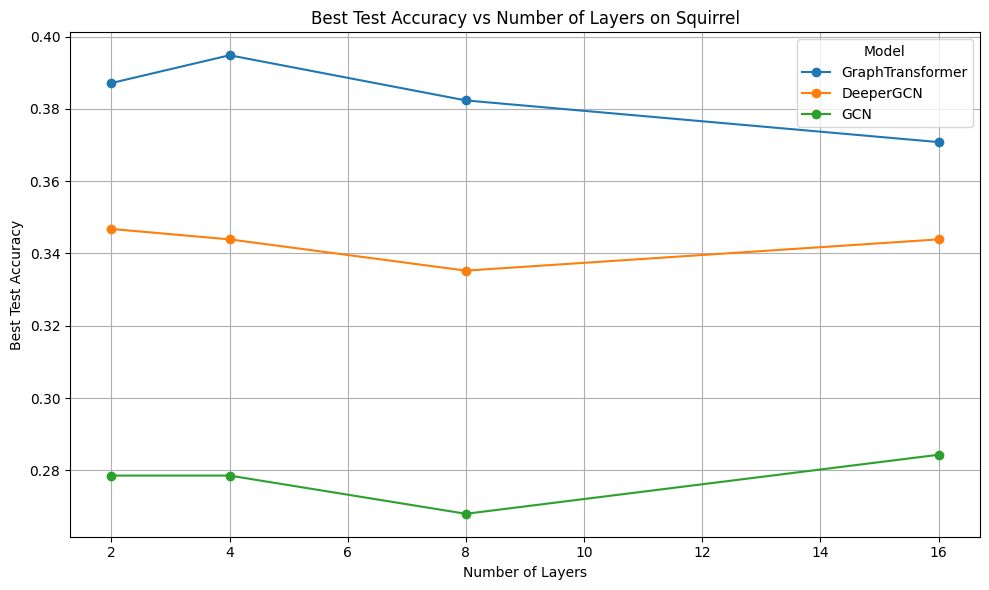

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_accuracy_vs_layers(summary_csv='summary_results.csv', results_dir='.'):
    """
    Plots the Best Test Accuracy against the Number of Layers for each model across all datasets.

    Parameters:
    - summary_csv (str): Name of the aggregated summary CSV file.
    - results_dir (str): Directory where the summary CSV file is located.
    """
    file_path = os.path.join(results_dir, summary_csv)

    if not os.path.exists(file_path):
        print(f"Summary file '{file_path}' not found.")
        return

    try:
        summary_df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading '{file_path}': {e}")
        return

    # Verify required columns exist
    required_columns = {'Dataset', 'Model', 'Layers', 'Best Test Acc'}
    if not required_columns.issubset(summary_df.columns):
        print(f"Summary CSV is missing one or more required columns: {required_columns}")
        return

    datasets = summary_df['Dataset'].unique()
    for dataset in datasets:
        plt.figure(figsize=(10, 6))
        df_dataset = summary_df[summary_df['Dataset'] == dataset]
        models = df_dataset['Model'].unique()

        for model in models:
            df_model = df_dataset[df_dataset['Model'] == model]
            x = df_model['Layers'].values
            y = df_model['Best Test Acc'].values

            # Sort the data by layers
            sorted_indices = np.argsort(x)
            x_sorted = x[sorted_indices]
            y_sorted = y[sorted_indices]

            # Plot the data points with lines
            plt.plot(x_sorted, y_sorted, marker='o', linestyle='-', label=model)

        plt.title(f'Best Test Accuracy vs Number of Layers on {dataset}')
        plt.xlabel('Number of Layers')
        plt.ylabel('Best Test Accuracy')
        plt.legend(title='Model')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Optional: Save the plot to a file within the results directory
        # save_path = os.path.join(results_dir, f'accuracy_vs_layers_{dataset}.png')
        # plt.savefig(save_path)

# Example usage:
plot_accuracy_vs_layers('summary_results.csv', results_dir='.')


#  Plot Accuracy vs. Number of Layers


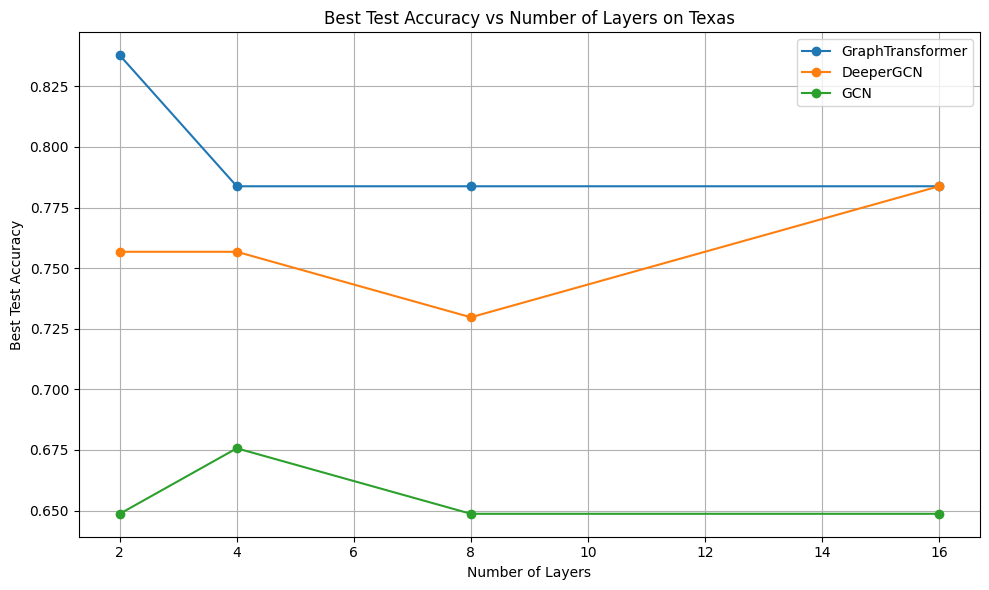

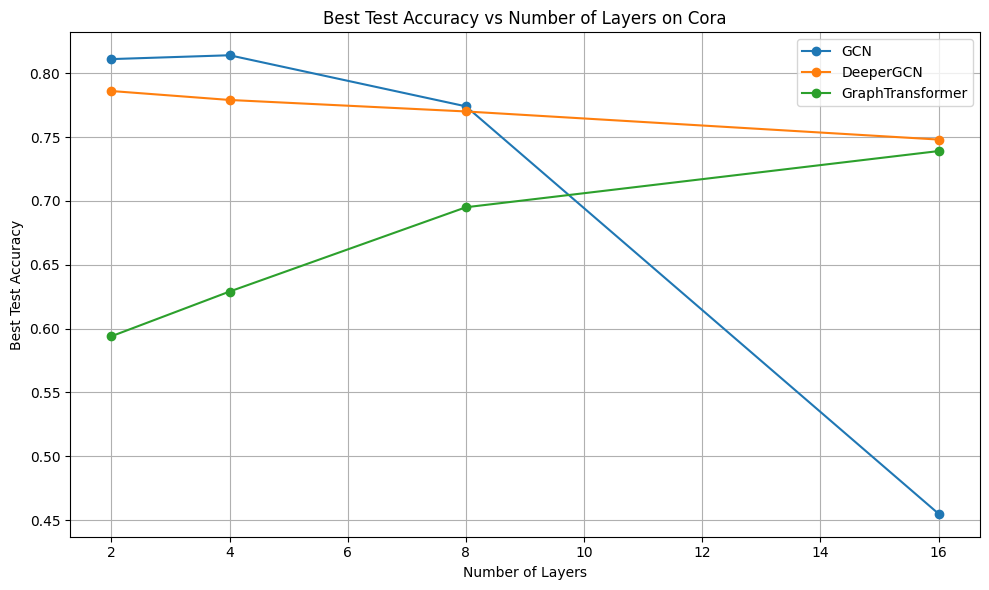

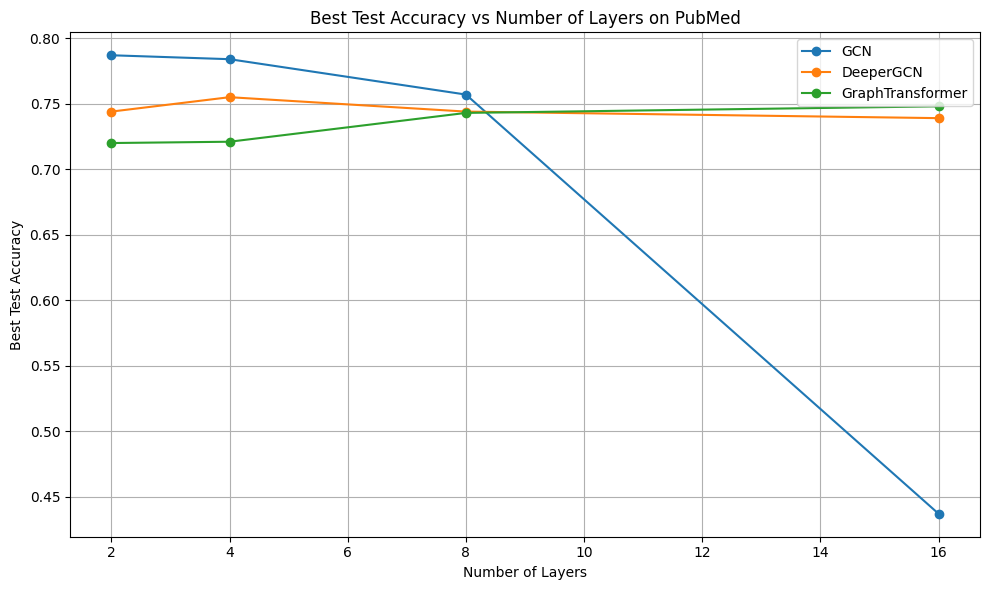

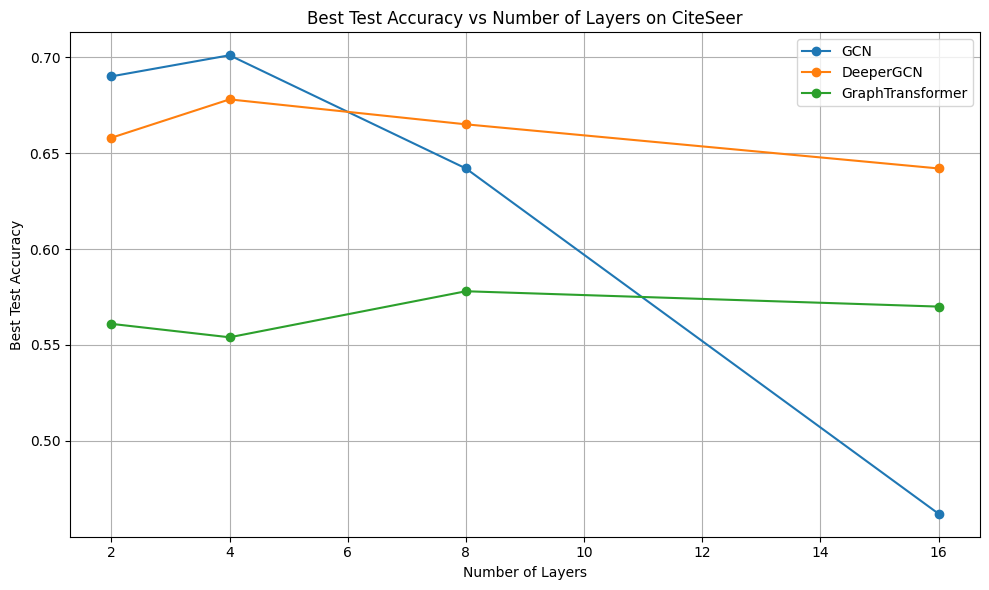

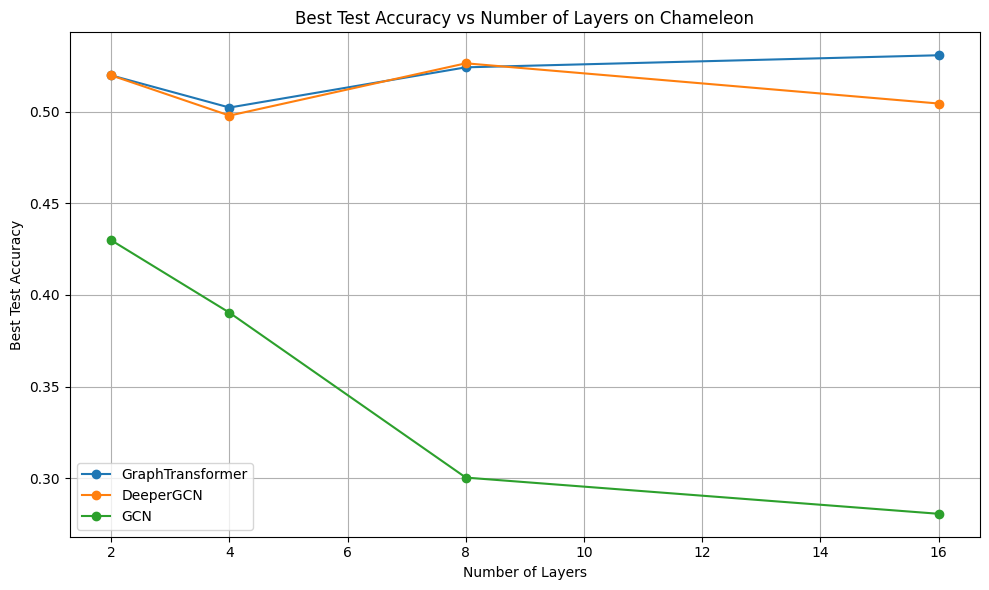

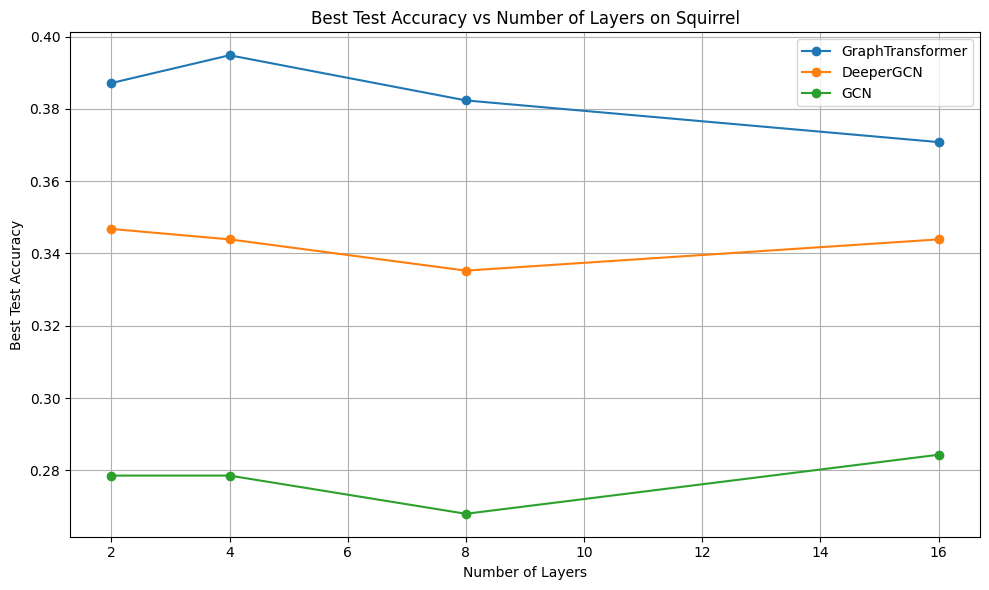

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_vs_layers(summary_csv='summary_results.csv'):
    try:
        summary_df = pd.read_csv(summary_csv)
    except FileNotFoundError:
        print(f"Summary file {summary_csv} not found.")
        return

    datasets = summary_df['Dataset'].unique()
    for dataset in datasets:
        plt.figure(figsize=(10, 6))
        df_dataset = summary_df[summary_df['Dataset'] == dataset]
        models = df_dataset['Model'].unique()

        for model in models:
            df_model = df_dataset[df_dataset['Model'] == model]
            x = df_model['Layers'].values
            y = df_model['Best Test Acc'].values

            # Sort the data by layers
            sorted_indices = np.argsort(x)
            x = x[sorted_indices]
            y = y[sorted_indices]

            # Plot the data points with lines
            plt.plot(x, y, marker='o', linestyle='-', label=model)

            # Optionally, plot the original data points as scatter
            # plt.scatter(x, y, s=50)  # Uncomment if you want both lines and scatter

        plt.title(f'Best Test Accuracy vs Number of Layers on {dataset}')
        plt.xlabel('Number of Layers')
        plt.ylabel('Best Test Accuracy')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Optional: Save the plot to a file
        # plt.savefig(f'accuracy_vs_layers_{dataset}.png')

# Example usage:
plot_accuracy_vs_layers()


#  Perform Statistical Analysis

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

def statistical_analysis(summary_csv='summary_results.csv', metric='Best Test Acc'):
    try:
        summary_df = pd.read_csv(summary_csv)
    except FileNotFoundError:
        print(f"Summary file {summary_csv} not found.")
        return

    models = summary_df['Model'].unique()
    if len(models) < 2:
        print("Need at least two models for statistical comparison.")
        return

    # Assuming we are comparing the first two models
    model1_data = summary_df[summary_df['Model'] == models[0]][metric]
    model2_data = summary_df[summary_df['Model'] == models[1]][metric]

    # Ensure there are enough data points
    if len(model1_data) < 2 or len(model2_data) < 2:
        print("Not enough data points for t-test.")
        return

    t_stat, p_value = ttest_ind(model1_data, model2_data)
    print(f"T-test between models '{models[0]}' and '{models[1]}' for {metric}:")
    print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Example usage:
statistical_analysis()


Summary file summary_results.csv not found.


# Plots the performance of a model against the logarithm of the number of parameters.

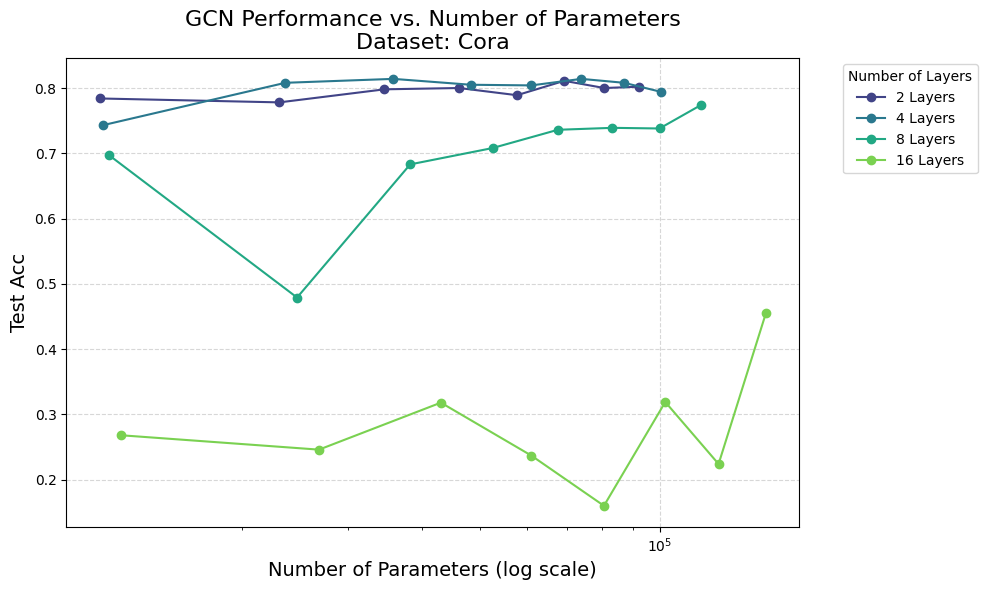

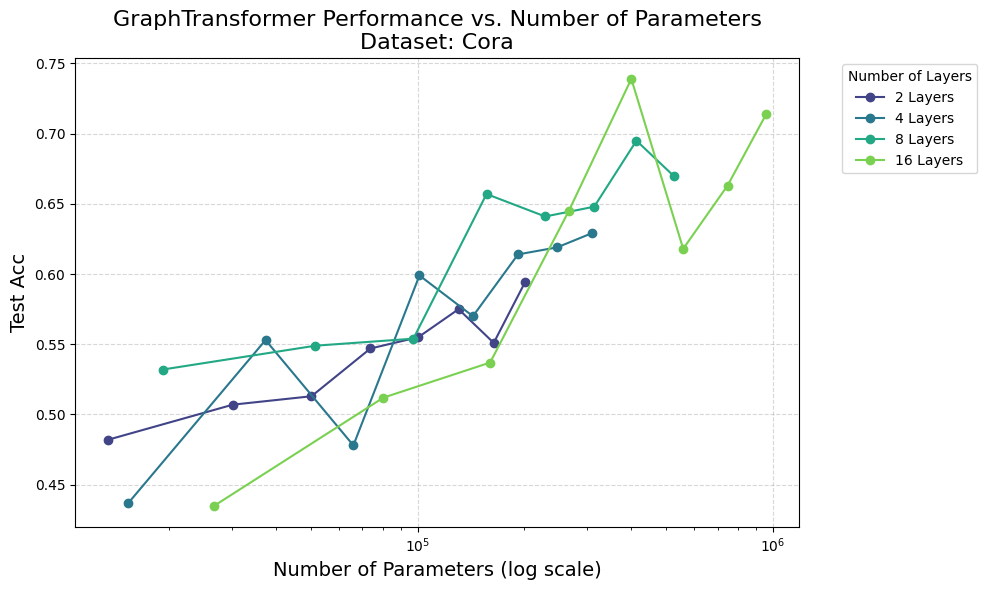

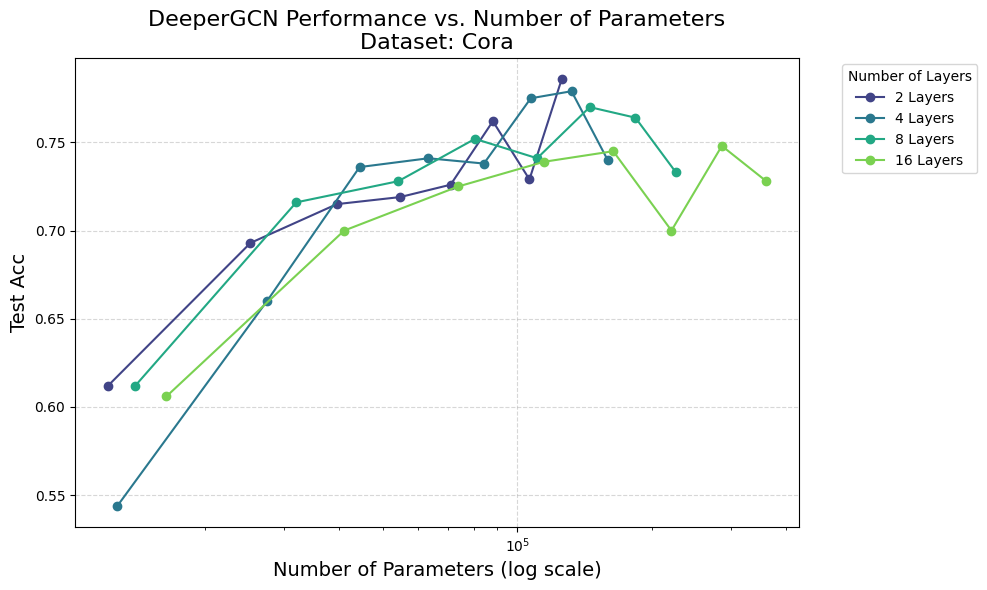

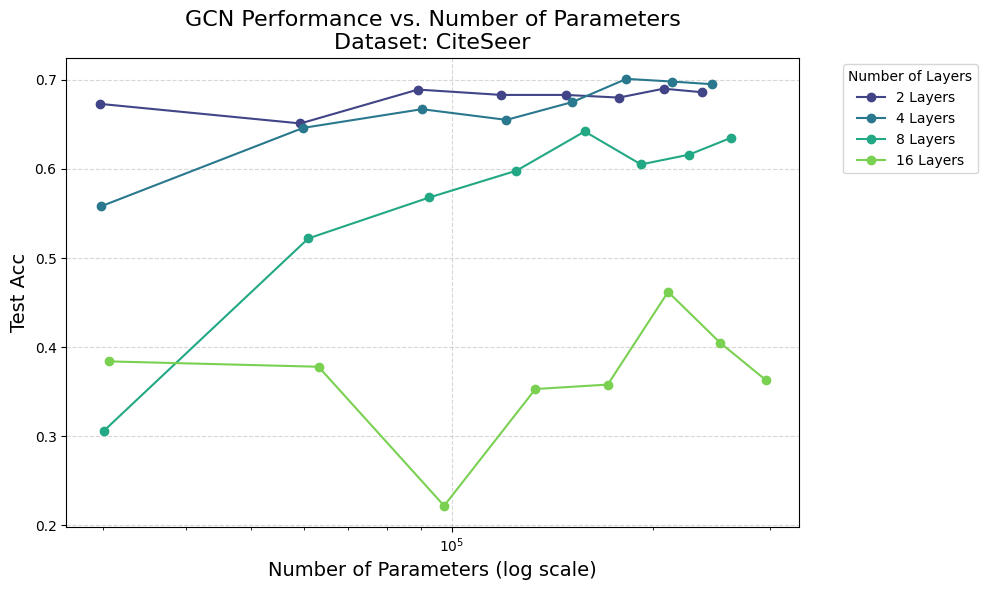

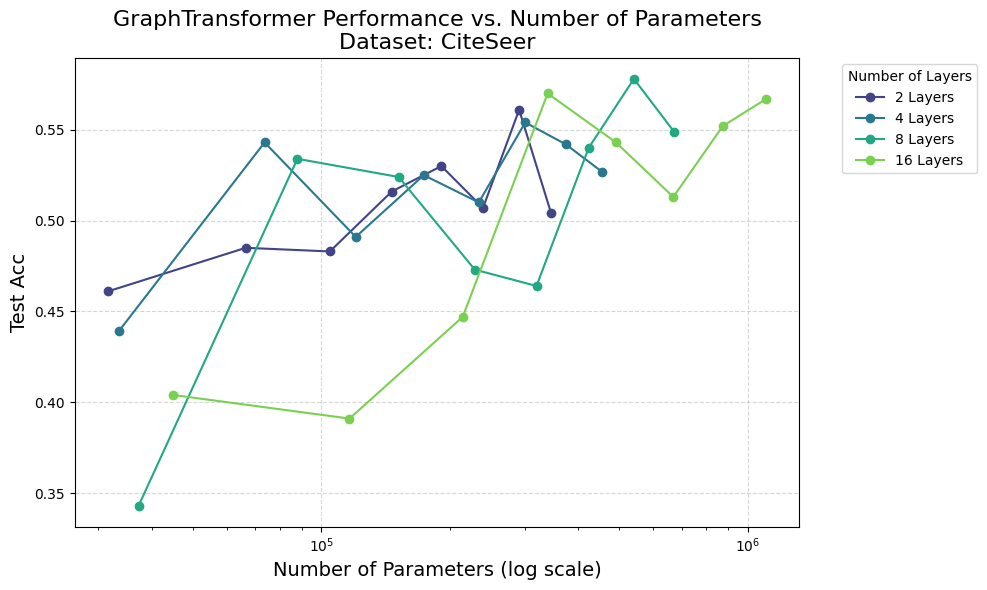

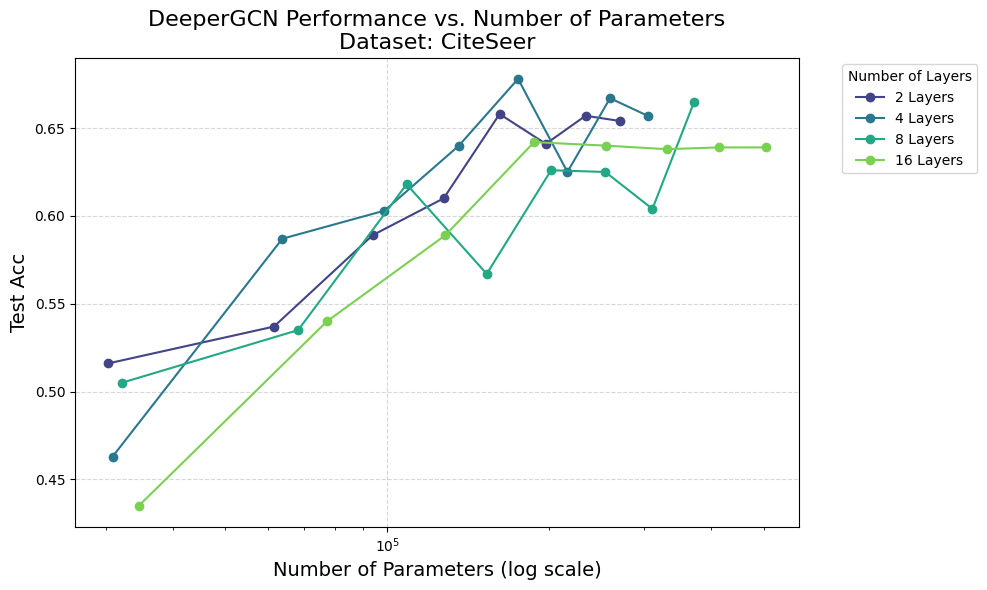

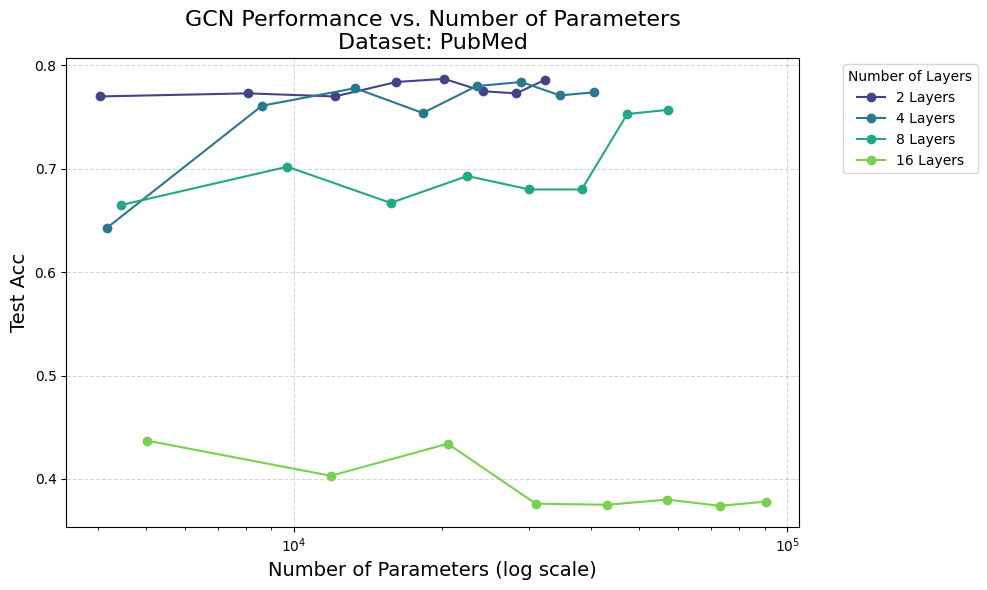

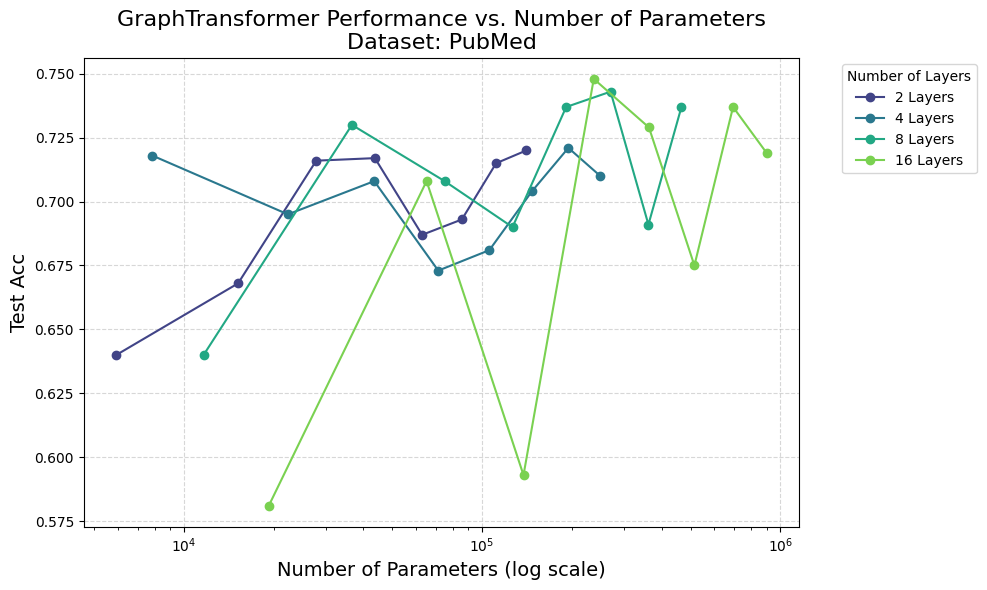

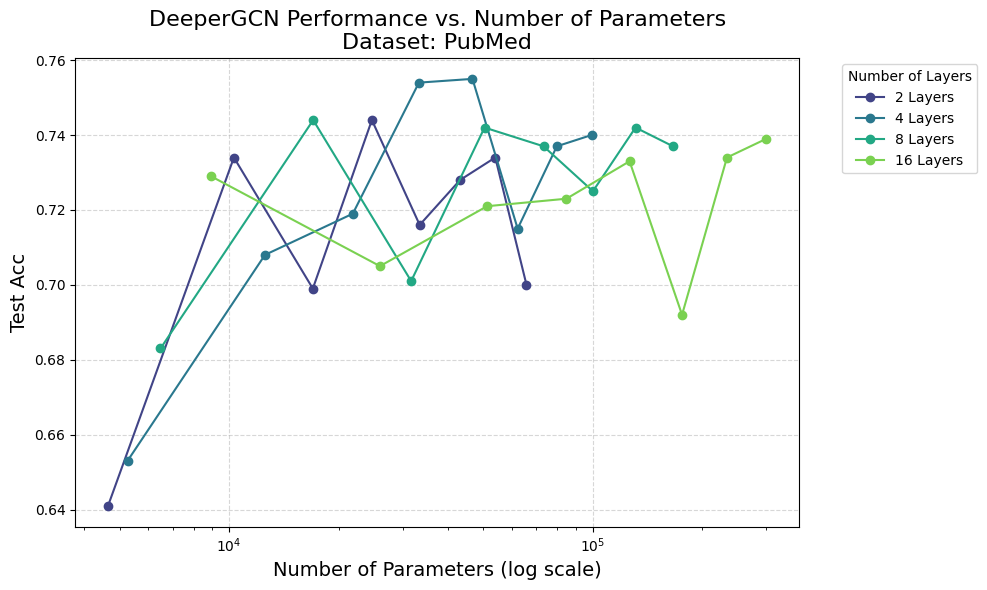

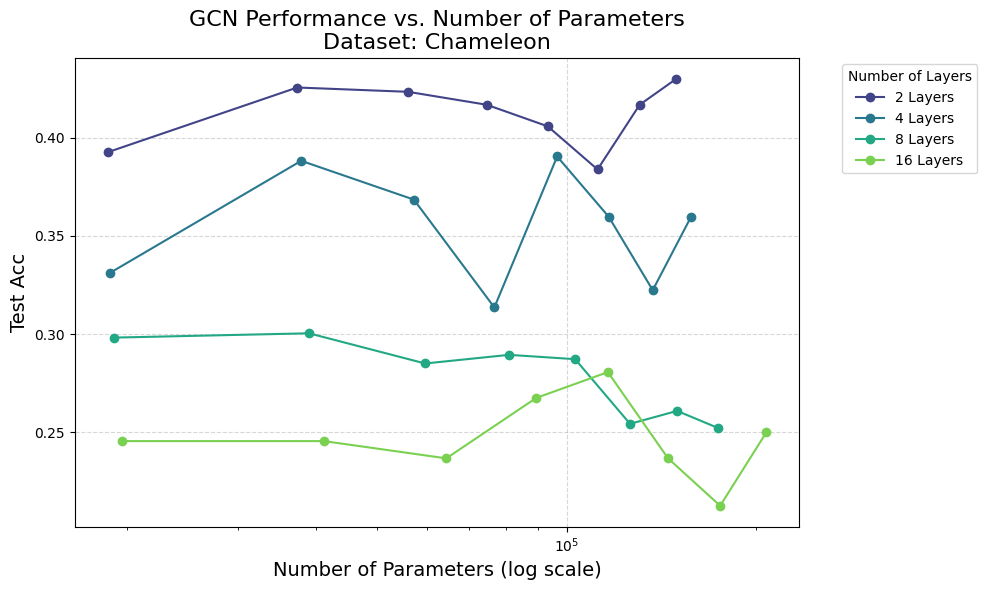

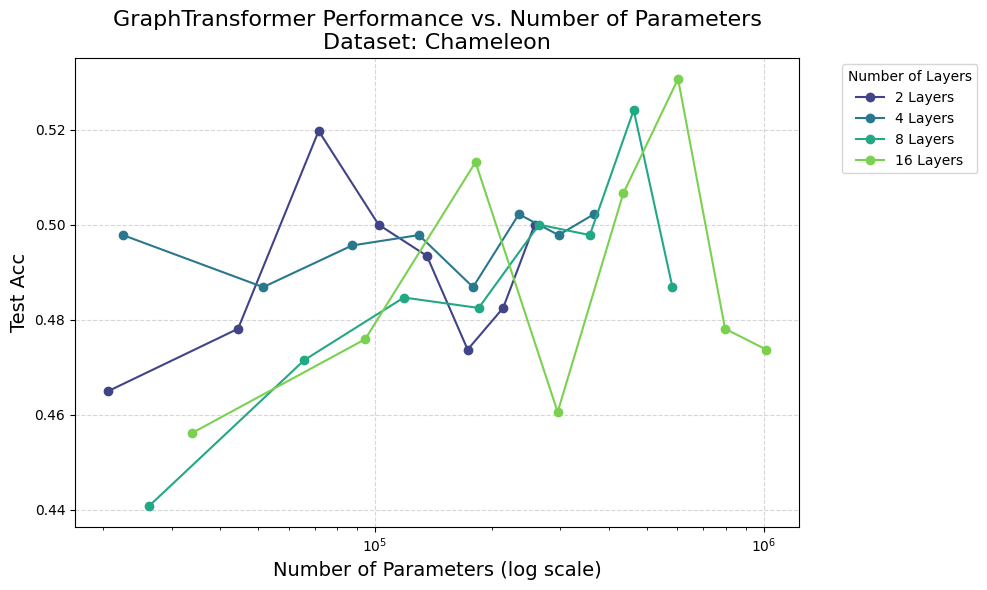

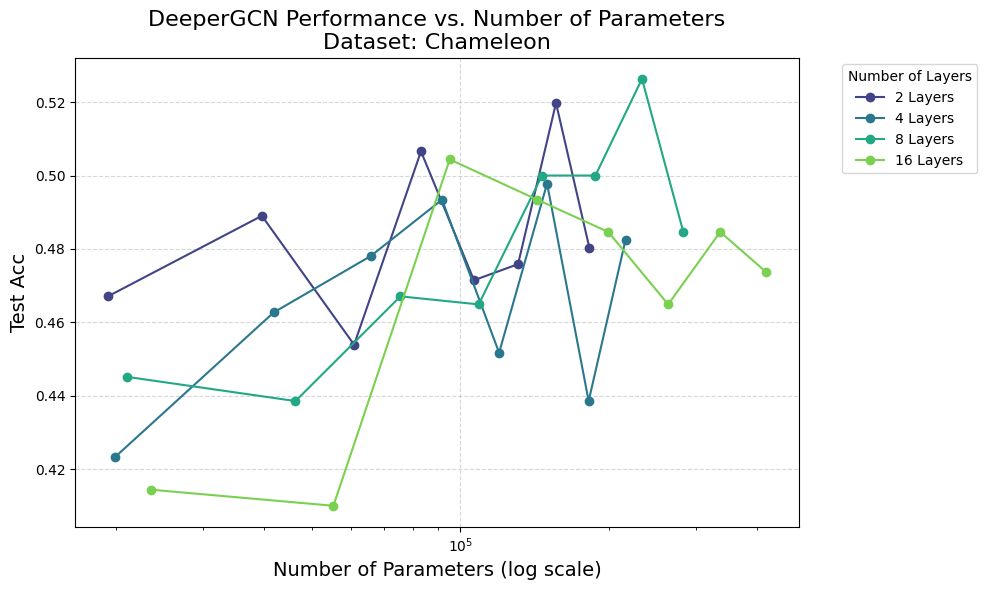

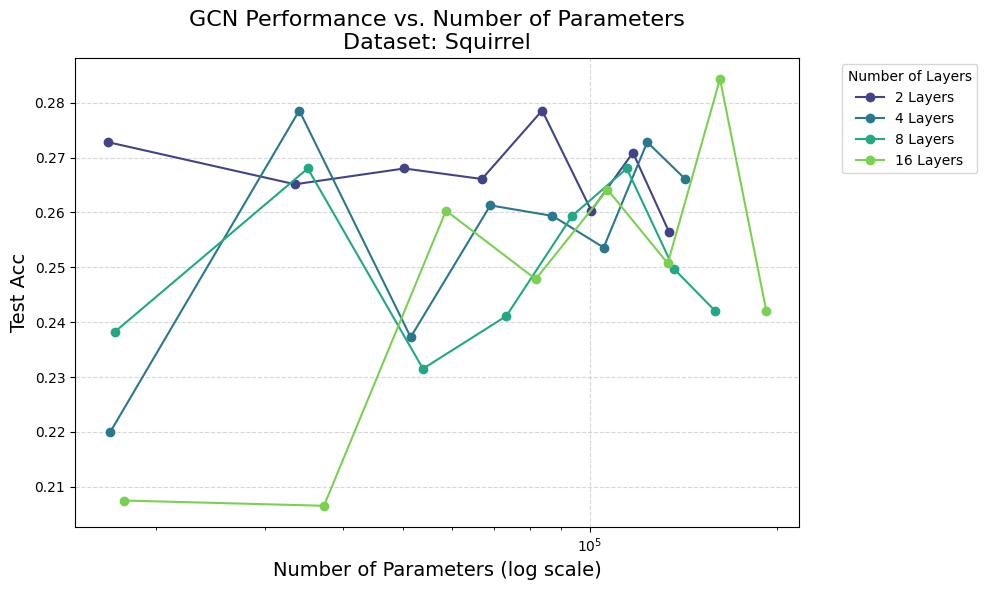

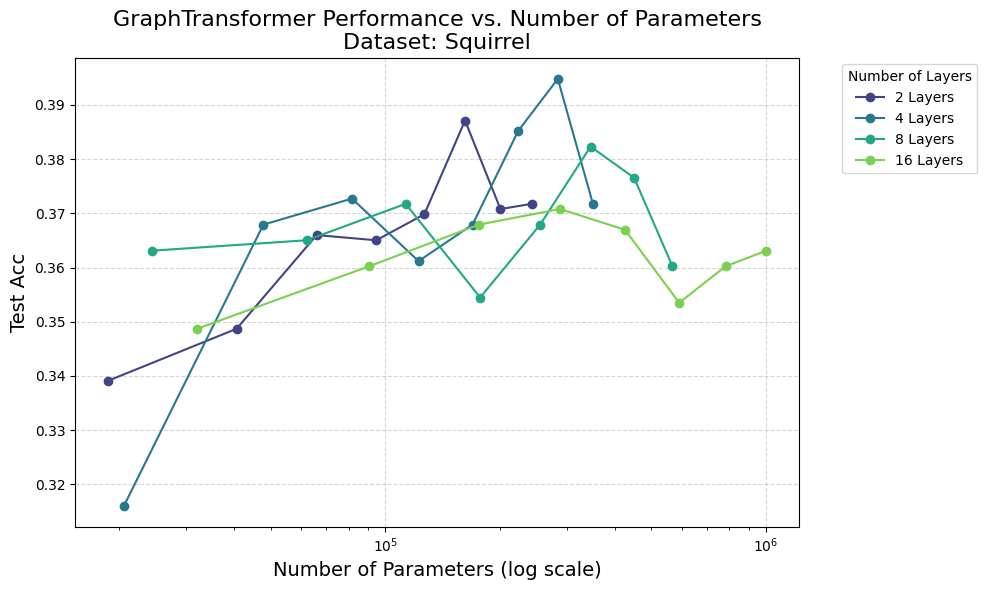

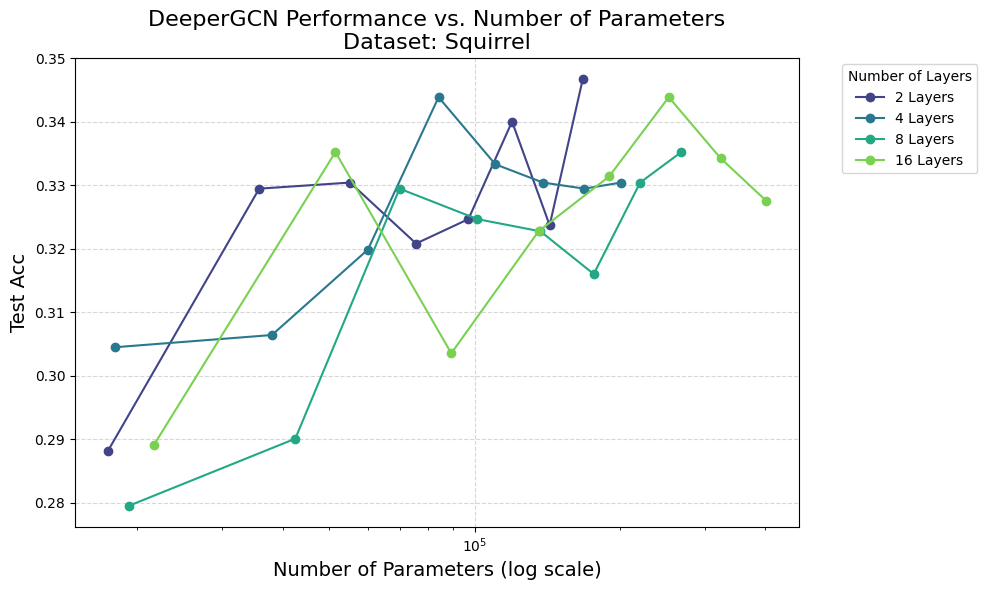

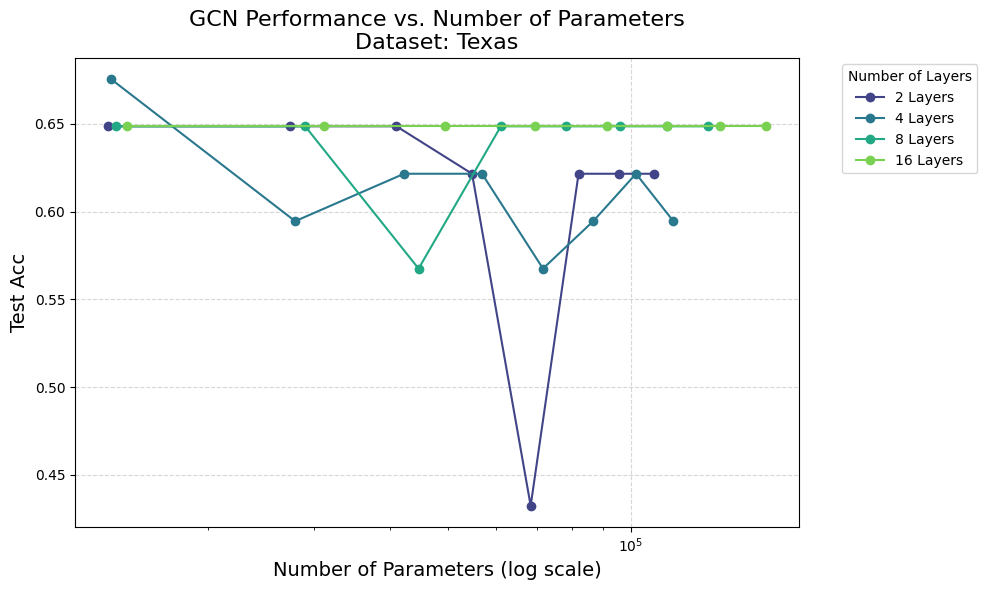

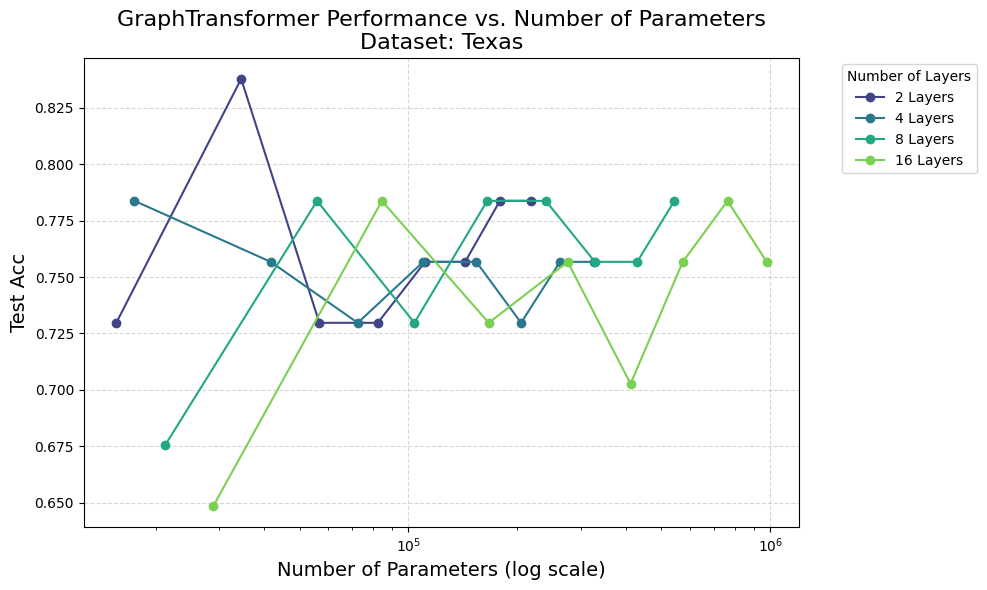

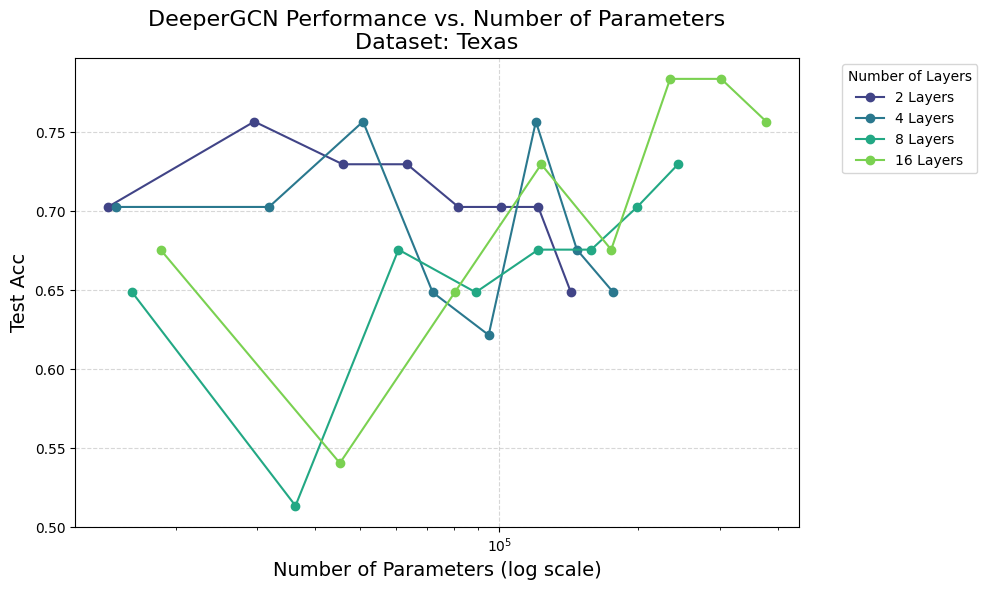

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_layer_performance(data, dataset_name, metric='test_acc'):
    """
    Plots the performance of each layer across the number of parameters for each model without smoothing.

    Parameters:
    - data (pd.DataFrame): The dataset containing model performance information.
    - dataset_name (str): The name of the dataset to filter the data on.
    - metric (str): The performance metric to plot ('test_acc' or 'val_acc').
    """
    # Filter data for the specific dataset
    filtered_data = data[data['dataset'] == dataset_name]

    if filtered_data.empty:
        print(f"No data available for dataset '{dataset_name}'.")
        return

    # Get unique models
    models = filtered_data['model'].unique()

    # Loop through each model to generate separate plots
    for model in models:
        model_data = filtered_data[filtered_data['model'] == model]

        # Define unique layers for this model
        layers = sorted(model_data['num_layers'].unique())

        plt.figure(figsize=(10, 6))
        colors = sns.color_palette('viridis', n_colors=len(layers))

        for idx, num_layer in enumerate(layers):
            layer_data = model_data[model_data['num_layers'] == num_layer]

            # Sort by number of parameters
            layer_data = layer_data.sort_values(by='num_params')
            x = layer_data['num_params'].values
            y = layer_data[metric].values

            # Plot raw data points connected by lines
            plt.plot(x, y, label=f'{num_layer} Layers', color=colors[idx], marker='o')

        # Set up plot labels and title
        plt.xscale('log')  # Logarithmic scale for parameters
        plt.xlabel('Number of Parameters (log scale)', fontsize=14)
        plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
        plt.title(f'{model} Performance vs. Number of Parameters\nDataset: {dataset_name}', fontsize=16)
        plt.legend(title='Number of Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(alpha=0.5, linestyle='--')
        plt.tight_layout()
        plt.show()


# Load your data
data_path = 'advanced_models_summary.csv'  # Replace with your actual file path
data = pd.read_csv(data_path)


dataset_name = 'Cora'  # Change this to the desired dataset
plot_layer_performance(data, dataset_name, metric='test_acc')

dataset_name = 'CiteSeer'  # Change this to the desired dataset
plot_layer_performance(data, dataset_name, metric='test_acc')

dataset_name = 'PubMed'  # Change this to the desired dataset
plot_layer_performance(data, dataset_name, metric='test_acc')



dataset_name = 'Chameleon'  # Change this to the desired dataset
plot_layer_performance(data, dataset_name, metric='test_acc')

dataset_name = 'Squirrel'  # Change this to the desired dataset
plot_layer_performance(data, dataset_name, metric='test_acc')

dataset_name = 'Texas'  # Change this to the desired dataset
plot_layer_performance(data, dataset_name, metric='test_acc')

